Задачи проекта:

Загрузить данные и подготовить к анализу

Анализ данных
- Соотношение видов объектов общественного питания по количеству. Построить график
- Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график
- Определить, для каких объектов характерно сетевое распределение
- Определить, что характерно для сетевых заведений: много заведений с небольшой посадкой или наоборот
- Описать среднее количество посадочных мест для каждого вида объекта общественного питания. Построить графики
- Выделить в отдельный столбец информацию об улице из столбца address
- Построить граифк топ-10 улиц по количеству объектов общественного питания. Понять, в каких районах Москвы находятся эти улицы
- Изучить распределение количества посадочных мест для улиц с большим количеством объектов общественного питания и выявить закономерности
- Сделать общий вывод и дать рекомендации о виде заведения, количестве посадочных мест и районе расположения. Указать на пути развития сети

Подготовка презентации

### Загрузить данные и подготовить к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
from bs4 import BeautifulSoup
import requests
from io import BytesIO

Загрузим датасет и выполним предобработку данных - заголовки столбцов, тип данных, дубликаты и пропуски

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Преобразуем названия столбцов

In [4]:
rest_data.rename(columns = {'id':'id', 'object_name':'name', 'chain':'chain', 
                            'object_type':'type', 'address':'address', 'number':'number'}, inplace=True)

In [5]:
rest_data.isnull().sum()

id         0
name       0
chain      0
type       0
address    0
number     0
dtype: int64

In [6]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id         15366 non-null int64
name       15366 non-null object
chain      15366 non-null object
type       15366 non-null object
address    15366 non-null object
number     15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропуски отсутствуют, тип данных корректный во всех столбцах. Проверим значения в столбцах.

In [7]:
rest_data = rest_data.drop_duplicates().reset_index(drop=True)

In [8]:
rest_data['type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: type, dtype: int64

В типах заведений нет противоречивых категорий, предобработка не требуется

In [9]:
rest_data['name'].value_counts()

Столовая                        267
Кафе                            236
Шаурма                          234
KFC                             155
Шоколадница                     142
                               ... 
Охунова У.Д.                      1
БУФЕТ МУЗ.ШКОЛА ИМ. ГНЕСИНЫХ      1
Кафе «Breakfast Club»             1
Клюква                            1
Арамье                            1
Name: name, Length: 10393, dtype: int64

Отбросим дубликаты по параметрам названия, сети, вида и адреса

In [10]:
rest_data['name'] = rest_data['name'].str.lower()

In [11]:
rest_data = rest_data.drop_duplicates(subset=['name','chain','type','address'], keep=False)

In [12]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15058 entries, 0 to 15364
Data columns (total 6 columns):
id         15058 non-null int64
name       15058 non-null object
chain      15058 non-null object
type       15058 non-null object
address    15058 non-null object
number     15058 non-null int64
dtypes: int64(2), object(4)
memory usage: 823.5+ KB


Выявлено 308 дублей в датасете. Это 2% от общего объема данных, что позволяет нам продолжить исследование

Выделим из столбца с адресом города и оставим только Москву

In [13]:
city_names = ['город','поселение','посёлок','поселок']
 
def get_city(address):
    for position in [0]:
        for address_part in address.split(',')[position].split(' '):          
            if address_part in city_names:
                city = address.split(', ')[position]
                return city

In [14]:
rest_data['city'] = rest_data['address'].apply(get_city)

In [15]:
rest_msc = rest_data[rest_data['city'] == 'город Москва'].reset_index()

In [16]:
rest_msc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 8 columns):
index      14987 non-null int64
id         14987 non-null int64
name       14987 non-null object
chain      14987 non-null object
type       14987 non-null object
address    14987 non-null object
number     14987 non-null int64
city       14987 non-null object
dtypes: int64(3), object(5)
memory usage: 936.8+ KB


Среди наименований есть противоречивые данные. Так, встречаются заведения с названием Столовая и СТОЛОВАЯ. В случае с категорией заведений решение данного вопроса критически сказывается на результаты исследлования. В данном случае речь идет о названии заведений, которые могут обладать уникальными признаками (те же Столовая и СТОЛОВАЯ - это могут быть две разные сети общественного питания)

Результаты предобратоки данных:
1. В исходном датасете 15366 строк, и 6 столбцов с информацией о каждой точке общепита
2. Пропуски в данных отсутвутют
3. Формат данных корректный и не требует изменений
4. Выделены строки заведений, относящихся только к Москве - 14987 точек общепита

### Анализ данных

#### Соотношение видов объектов общественного питания по количеству. Построить график

In [17]:
rest_data_by_types = rest_msc.groupby('type')['id'].agg('count').reset_index()
rest_data_by_types

,type,id
0,бар,849
1,буфет,553
2,закусочная,341
3,кафе,5919
4,кафетерий,386
5,магазин (отдел кулинарии),270
6,предприятие быстрого обслуживания,1859
7,ресторан,2253
8,столовая,2557


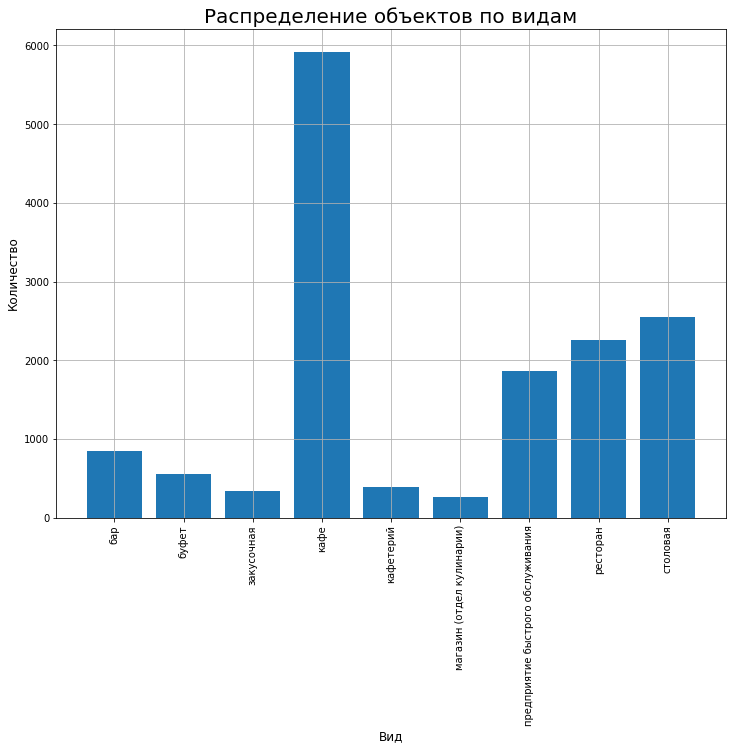

In [18]:
plt.figure(figsize=(12, 9))
plt.bar(rest_data_by_types['type'], rest_data_by_types['id'])
plt.title('Распределение объектов по видам', fontsize=20)
plt.xlabel('Вид', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation = 90)
plt.grid();

Исходя их графика и сгруппированной таблицы видно следующее:
1. Наиболее распространенным видом заведения общепита является Кафе - около 6000;
2. Следом располагаются Столовая, Ресторан и Предприятие быстрого обслуживания от 1900 до 2600;
3. Наименьшее количество заведений в типах Закусочная, Кафетерий и Магазин (отдел кулинарии) - менее 400.

Судя по всему, данное распределение объясняется спросом на определенный тип заведений и их популярность, а также ценовую доступность и тип кухни (алкоголь, выпечка, наличие полноценной собственной кухни и др.)

#### Исследовать соотношение сетевых и несетевых заведений по количеству. Построить график

In [19]:
rest_data_by_chain = rest_msc.groupby('chain')['id'].agg('count').reset_index()

In [20]:
rest_data_by_chain

,chain,id
0,да,2918
1,нет,12069


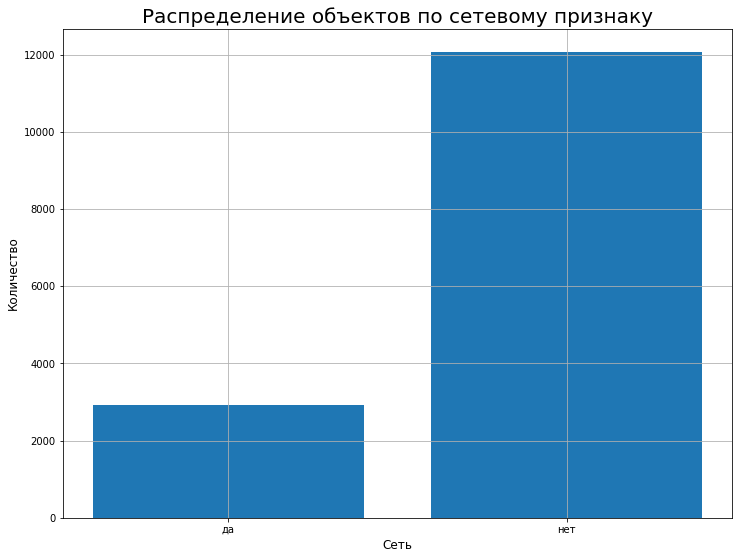

In [21]:
plt.figure(figsize=(12, 9))
plt.bar(rest_data_by_chain['chain'], rest_data_by_chain['id'])
plt.title('Распределение объектов по сетевому признаку', fontsize=20)
plt.xlabel('Сеть', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid();

Распределение указывает на очевидное преимущество несетевых заведений - 12069 против 2918

#### Определить, для каких объектов характерно сетевое распределение

In [22]:
rest_data_by_types_and_chain = rest_msc.groupby(['type', 'chain'])['id'].agg('count').reset_index()
rest_data_by_types_and_chain = rest_data_by_types_and_chain.rename(columns={'type':'type', 'chain':'chain', 'id':'sum'})
rest_data_by_types_total = rest_msc.groupby('type')['id'].agg('count').reset_index()
rest_data_by_types_total = rest_data_by_types_total.rename(columns={'type':'type', 'id':'total'})

In [23]:
rest_data_by_types_and_chain = rest_data_by_types_and_chain[rest_data_by_types_and_chain['chain'] == 'да']
rest_data_by_types_and_chain

,type,chain,sum
0,бар,да,37
2,буфет,да,11
4,закусочная,да,56
6,кафе,да,1372
8,кафетерий,да,50
10,магазин (отдел кулинарии),да,78
12,предприятие быстрого обслуживания,да,773
14,ресторан,да,538
16,столовая,да,3


In [24]:
rest_data_by_types_and_chain = rest_data_by_types_and_chain.merge(rest_data_by_types_total, on='type')

In [25]:
rest_data_by_types_and_chain['part'] = (rest_data_by_types_and_chain['sum'] / rest_data_by_types_and_chain['total']).round(3)
rest_data_by_types_and_chain

,type,chain,sum,total,part
0,бар,да,37,849,0.044
1,буфет,да,11,553,0.020
2,закусочная,да,56,341,0.164
3,кафе,да,1372,5919,0.232
4,кафетерий,да,50,386,0.130
5,магазин (отдел кулинарии),да,78,270,0.289
6,предприятие быстрого обслуживания,да,773,1859,0.416
7,ресторан,да,538,2253,0.239
8,столовая,да,3,2557,0.001


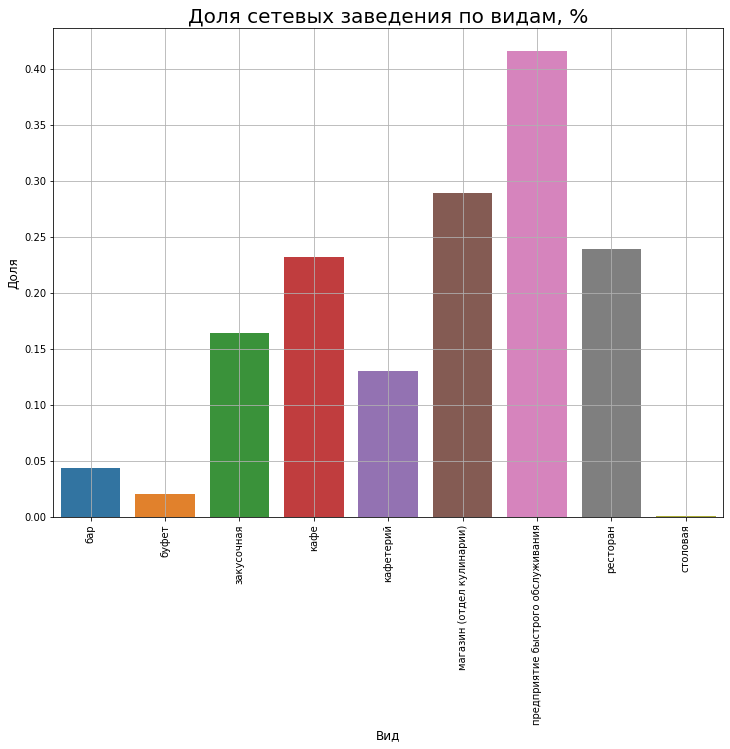

In [26]:
plt.figure(figsize=(12, 9))
sns.barplot(data=rest_data_by_types_and_chain, x='type', y='part')
plt.title('Доля сетевых заведения по видам, %', fontsize=20)
plt.xlabel('Вид', fontsize=12)
plt.ylabel('Доля', fontsize=12)
plt.xticks(rotation = 90)
plt.grid();

Категориальное распределение показало, что наиболее характерно сетевое распределение для предприятий быстрого обслуживания. Также большую долю сетевые общепиты занимают в закусочных, кафе, ресторанах и отделах кулинарии в магазинах

#### Определить, что характерно для сетевых заведений: много заведений с небольшой посадкой или наоборот

In [27]:
rest_data_chain = rest_msc[rest_msc['chain'] == 'да'].sort_values('number', ascending='False')

In [28]:
rest_data_chain['number'].describe(percentiles=(0.5, 0.8, 0.9))

count    2918.000000
mean       52.923578
std        56.843873
min         0.000000
50%        40.000000
80%        86.000000
90%       120.000000
max       580.000000
Name: number, dtype: float64

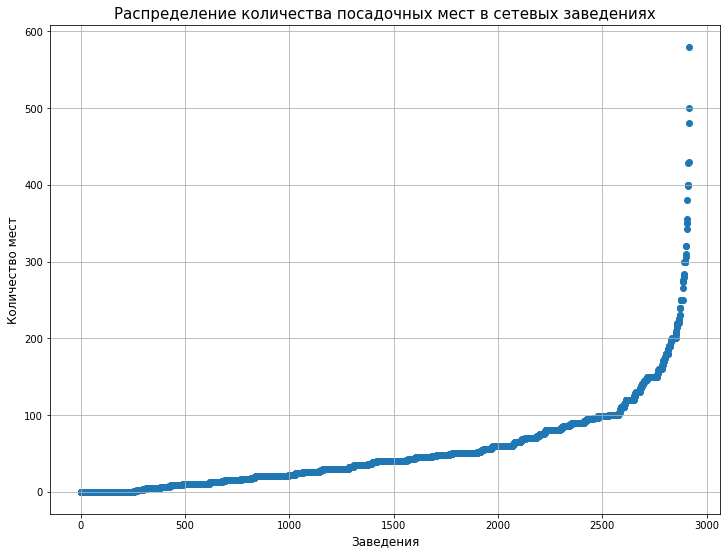

In [29]:
number_scatter = pd.Series(range(0, len(rest_data_chain['name'])))

plt.figure(figsize=(12, 9))

plt.scatter(number_scatter, rest_data_chain['number'], label = 'Сетевые')
plt.title('Распределение количества посадочных мест в сетевых заведениях', fontsize=15)
plt.xlabel('Заведения', fontsize=12)
plt.ylabel('Количество мест', fontsize=12)
plt.grid();

Распределение количества посадочных мест показывает, что до значения 100 идет постепенное увеличение количества мест от одного заведения к другому. После идет резкий рост (от 100 до 600). Статистическая характеристика подтверждает данное наблюдение и указывает, что 90% заведения имеют количество посадочных мест менее 120. 

На основе полученных данных можно заключить, что для сетевых заведений более характерно большое количество заведений с небольшой посадкой.

#### Описать среднее количество посадочных мест для каждого вида объекта общественного питания. Построить графики

In [30]:
numer_mean_by_types = rest_msc.groupby('type', as_index=False).agg({'number':'mean'}).round().sort_values('number', ascending=False)
numer_mean_by_types

,type,number
8,столовая,131.0
7,ресторан,97.0
1,буфет,52.0
0,бар,44.0
3,кафе,40.0
6,предприятие быстрого обслуживания,21.0
4,кафетерий,9.0
2,закусочная,8.0
5,магазин (отдел кулинарии),6.0


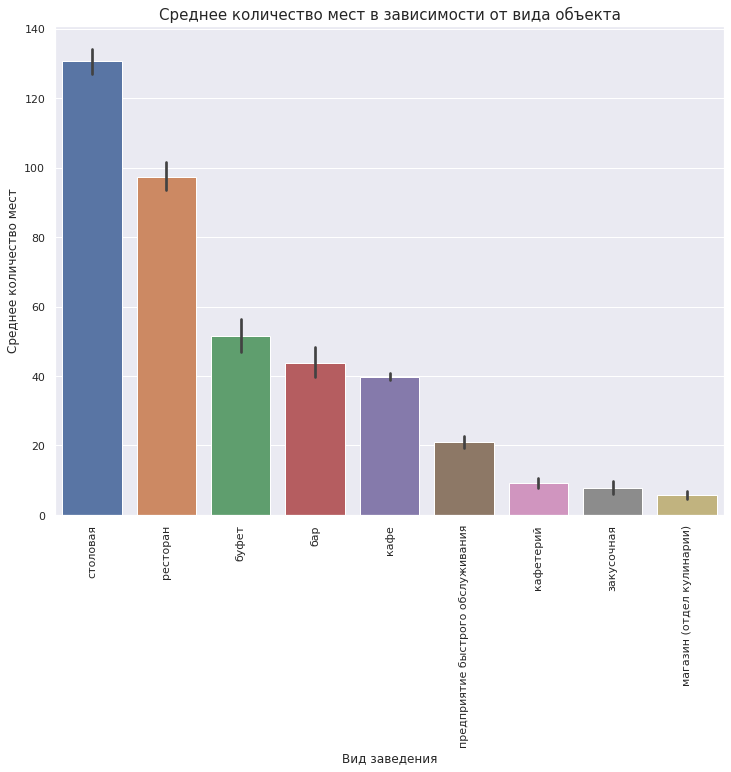

In [31]:
sns.set(rc={'figure.figsize':(12,9)})

number_for_barplots = (rest_msc.groupby('type', as_index=False)
                      .agg({'number':'mean'})
                      .sort_values('number', ascending=False)
                      .type
                      .array)
sns.barplot(x='type', y='number', data=rest_msc, order=number_for_barplots)
plt.xticks(rotation=90)
plt.title('Среднее количество мест в зависимости от вида объекта', fontsize=15)
plt.xlabel('Вид заведения', fontsize=12)
plt.ylabel('Среднее количество мест', fontsize=12);

Распределение по среднему количеству посадочных мест показывает, что больше всего мест в столовых - 131 и ресторанах - 97. Это объясняется спецификой заведений и потребностью в одновременном обслуживании большого количества гостей на месте. В случае с кафетерием, закусочной и отделом кулинарии в магазинах ситуация обратная и среднее количество посадочных мест не превышает 10

#### Выделить в отдельный столбец информацию об улице из столбца address

In [32]:
street_names = ['улица','проспект','шоссе','проезд',
                 'бульвар','переулок','набережная','площадь','вал','аллея']
 
def get_street(address):
    for position in [0,1,2]:
        for address_part in address.split(',')[position].split(' '):          
            if address_part in street_names:
                street = address.split(', ')[position]
                return street

In [33]:
rest_msc['street'] = rest_msc['address'].apply(get_street).copy()

In [34]:
rest_msc

,index,id,name,chain,type,address,number,city,street
0,0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,город Москва,улица Егора Абакумова
1,1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,город Москва,улица Талалихина
2,2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,город Москва,Абельмановская улица
3,3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,город Москва,Абрамцевская улица
4,4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,город Москва,Абрамцевская улица
...,...,...,...,...,...,...,...,...,...
14982,15358,213724,шоколадница,да,кафе,"город Москва, Варшавское шоссе, дом 87Б",54,город Москва,Варшавское шоссе
14983,15359,222077,кофейня «шоколадница»,да,кафе,"город Москва, Кантемировская улица, дом 47",72,город Москва,Кантемировская улица
14984,15360,219759,шоколадница,да,кафе,"город Москва, улица Вавилова, дом 3",36,город Москва,улица Вавилова
14985,15361,208537,шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,город Москва,3-й Крутицкий переулок


#### Построить график топ-10 улиц по количеству объектов общественного питания. Понять, в каких районах Москвы находятся эти улицы

Наиболее популярные улицы обнаружены, теперь определеим их районы

In [35]:
address_for_dist = rest_msc[['address']].drop_duplicates().reset_index(drop=True)

In [36]:
address_for_dist.head()

,address
0,"город Москва, улица Егора Абакумова, дом 9"
1,"город Москва, улица Талалихина, дом 2/1, корпус 1"
2,"город Москва, Абельмановская улица, дом 6"
3,"город Москва, Абрамцевская улица, дом 1"
4,"город Москва, Абрамцевская улица, дом 9, корпус 1"


С помощью Геокодера составим запросы для определения координат адресов и после осуществим запрос для получения района соответствующих координат. Полученные данные сохраним в таблице на google sheets.

In [37]:
#pip install geopy
#from geopy.geocoders import Yandex

#geolocator = Yandex(api_key="cd47a2f3-f9f5-472f-83a0-5d1cbed9d92a")
#URL = 'https://geocode-maps.yandex.ru/1.x/?apikey=cd47a2f3-f9f5-472f-83a0-5d1cbed9d92a'

#def coordinates(address):
#    try:
#        params = {'geocode':address}
#        request = requests.get(url = URL, params=params)
#        coords = BeautifulSoup(request.text, 'lxml').find('pos').text.split()
#        return coords
#    except:
#        return np.nan
    
#def area(coords):
#    try:
#        coords = ', '.join(map(str, coords))
#        params = {'geocode': coords, 'kind':'district', 'results':'1'}
#        request = requests.get(url = URL, params=params)
#        area = (BeautifulSoup(request.text, 'lxml')
#                .find_all('name', attrs={'xmlns':'http://www.opengis.net/gml'})[0]
#                .text
#               )
#        return area
#    except:
#        return np.nan

#address_for_dist['coordinates'] = address_for_dist['address'].apply(coordinates)
#address_for_dist['area'] = address_for_dist['coordinates'].apply(area)
#address_for_dist.to_csv('address_for_dist.csv', index=False, encoding='utf-16', sep=';')

In [38]:
spreadsheet_id = '1_lR0kCqKtOV-giq9TEhzAm7ypEyVuFLIi6C9EsUN80s'

In [39]:
coords_and_area_doc = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(coords_and_area_doc)
coords_and_area = pd.read_csv(BytesIO(r.content))

In [40]:
coords_and_area['street'] = coords_and_area['address'].apply(get_street).copy()
coords_and_area

,address,coordinates,area,street
0,"город Москва, улица Егора Абакумова, дом 9","['37.714474', '55.879005']",Ярославский район,улица Егора Абакумова
1,"город Москва, улица Талалихина, дом 2/1, корпус 1","['37.673295', '55.738307']",Таганский район,улица Талалихина
2,"город Москва, Абельмановская улица, дом 6","['37.669576', '55.735571']",Таганский район,Абельмановская улица
3,"город Москва, Абрамцевская улица, дом 1","['37.573007', '55.892713']",район Лианозово,Абрамцевская улица
4,"город Москва, Абрамцевская улица, дом 9, корпус 1","['37.572279', '55.904074']",район Лианозово,Абрамцевская улица
...,...,...,...,...
9019,"город Москва, Профсоюзная улица, дом 142, корп...","['37.509334', '55.625481']",1-4-й микрорайон,Профсоюзная улица
9020,"город Москва, Привольная улица, дом 11","['37.839214', '55.700618']",район Выхино-Жулебино,Привольная улица
9021,"город Москва, Салтыковская улица, дом 7Г","['37.86169', '55.733579']",3-й микрорайон Новокосино,Салтыковская улица
9022,"город Москва, Осенний бульвар, дом 9","['37.406765', '55.758255']",район Крылатское,Осенний бульвар


In [41]:
rest_msc = rest_msc.merge(coords_and_area, on='address')[['id', 'name', 'chain', 'type', 'address', 'number', 
                                                          'street_x', 'coordinates', 'area']].reset_index(drop=True)

In [42]:
rest_msc = rest_msc.rename(columns={'id':'id', 'name':'name', 'chain':'chain', 'type':'type', 'address':'address', 
                         'number':'number', 'street_x':'street', 'coordinates':'coordinates', 'area':'area'})

In [43]:
rest_msc

,id,name,chain,type,address,number,street,coordinates,area
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,"['37.714474', '55.879005']",Ярославский район
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,"['37.673295', '55.738307']",Таганский район
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,"['37.669576', '55.735571']",Таганский район
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица,"['37.573007', '55.892713']",район Лианозово
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица,"['37.572279', '55.904074']",район Лианозово
...,...,...,...,...,...,...,...,...,...
14982,222491,кальянная «мята lounge»,да,кафе,"город Москва, Профсоюзная улица, дом 142, корп...",40,Профсоюзная улица,"['37.509334', '55.625481']",1-4-й микрорайон
14983,212216,мята lounge,да,кафе,"город Москва, Привольная улица, дом 11",56,Привольная улица,"['37.839214', '55.700618']",район Выхино-Жулебино
14984,206341,мята lounge,да,кафе,"город Москва, Салтыковская улица, дом 7Г",100,Салтыковская улица,"['37.86169', '55.733579']",3-й микрорайон Новокосино
14985,213772,тануки,да,ресторан,"город Москва, Осенний бульвар, дом 9",98,Осенний бульвар,"['37.406765', '55.758255']",район Крылатское


In [44]:
rest_msc_top_10 = (rest_msc
                   .pivot_table(index='street', values='area', aggfunc='count')
                   .sort_values('area', ascending=False)
                   .reset_index()
                   .head(10)
                  )
rest_msc_top_10 = rest_msc_top_10.rename(columns={'street':'street', 'area':'total'})

In [45]:
rest_msc_top_10

,street,total
0,проспект Мира,188
1,Профсоюзная улица,178
2,Ленинградский проспект,169
3,Пресненская набережная,163
4,Варшавское шоссе,158
5,Ленинский проспект,147
6,проспект Вернадского,121
7,Кутузовский проспект,114
8,Каширское шоссе,108
9,Кировоградская улица,104


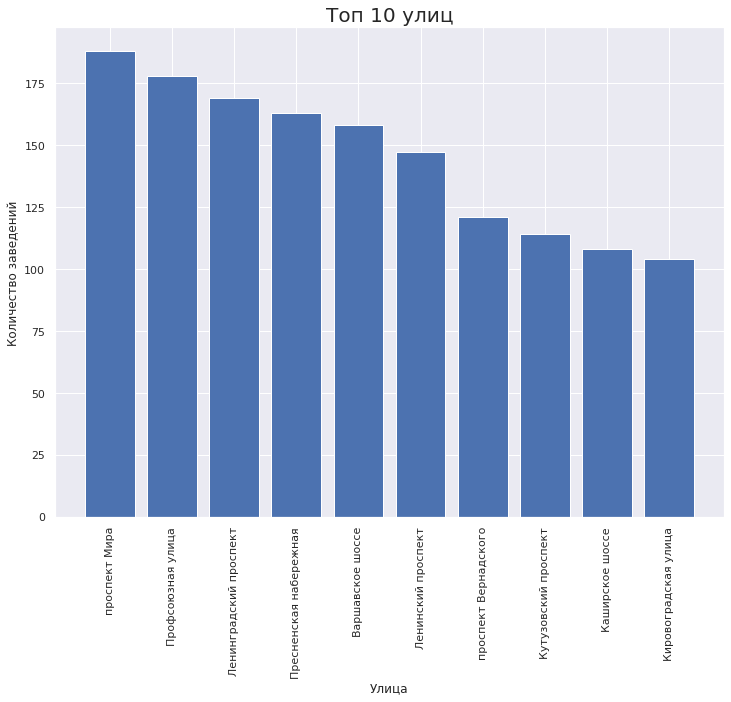

In [46]:
plt.figure(figsize=(12, 9))
plt.bar(rest_msc_top_10['street'], rest_msc_top_10['total'])
plt.title('Топ 10 улиц', fontsize=20)
plt.xlabel('Улица', fontsize=12)
plt.ylabel('Количество заведений', fontsize=12)
plt.xticks(rotation = 90);

In [47]:
top_10_merged = rest_msc_top_10.merge(rest_msc, on='street', how='left')
top_10_merged

,street,total,id,name,chain,type,address,number,coordinates,area
0,проспект Мира,188,149899,сухарева башня,нет,кафе,"город Москва, проспект Мира, дом 5, корпус 1",10,"['37.631918', '55.774219']",Мещанский район
1,проспект Мира,188,69300,ваби-саби,да,кафе,"город Москва, проспект Мира, дом 29",64,"['37.63252', '55.779803']",Мещанский район
2,проспект Мира,188,71378,шоколадница,да,кафе,"город Москва, проспект Мира, дом 29",40,"['37.63252', '55.779803']",Мещанский район
3,проспект Мира,188,146123,джаганнат,да,кафе,"город Москва, проспект Мира, дом 31",25,"['37.632592', '55.780122']",Мещанский район
4,проспект Мира,188,137644,krispy creme,да,кафе,"город Москва, проспект Мира, дом 40",36,"['37.633949', '55.780203']",Мещанский район
...,...,...,...,...,...,...,...,...,...,...
1448,Кировоградская улица,104,222905,"шаурма, куры гриль, выпечка",нет,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, владение 15А",0,"['37.603415', '55.609924']",район Чертаново Центральное
1449,Кировоградская улица,104,222913,шашлык на углях,нет,закусочная,"город Москва, Кировоградская улица, владение 15А",6,"['37.603415', '55.609924']",район Чертаново Центральное
1450,Кировоградская улица,104,191227,"предприятие быстрого обслуживания «шаурма, кур...",нет,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 12, ко...",0,"['37.608715', '55.623991']",район Чертаново Северное
1451,Кировоградская улица,104,191657,пиццерия «пицца хат»,да,кафе,"город Москва, Кировоградская улица, дом 23А",40,"['37.598995', '55.600389']",район Чертаново Южное


In [48]:
top_10_merged = top_10_merged[top_10_merged['area'].str.contains('район', na=False) &
                              ~(top_10_merged['area'].str.contains('микрорайон', na=False))]

In [49]:
print(top_10_merged['area'].unique())
print('Количество районов:', len(top_10_merged['area'].unique()))

['Мещанский район' 'Останкинский район' 'Алексеевский район'
 'район Ростокино' 'район Свиблово' 'Ярославский район'
 'Академический район' 'район Черёмушки' 'Обручевский район'
 '44-47-й квартал района Коньково' 'район Ясенево'
 '41-й квартал района Коньково' 'район Беговой' 'район Аэропорт'
 'район Сокол' 'Хорошёвский район' 'Донской район' 'Нагорный район'
 'район Чертаново Южное' 'район Чертаново Северное'
 'район Чертаново Центральное' 'район Нагатино-Садовники'
 'район Южное Бутово' 'район Якиманка' 'Гагаринский район'
 'Ломоносовский район' 'район Тропарёво-Никулино'
 'район Проспект Вернадского' 'район Раменки' 'район Фили-Давыдково'
 'район Дорогомилово' 'район Москворечье-Сабурово'
 'район Орехово-Борисово Южное' 'район Орехово-Борисово Северное']
Количество районов: 34


Наиболее популярными для заведений общественного питания оказались проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе и Ленинский проспект Также много заведений на проспекте Вернадского, Кутузовском проспекте, Каширском шоссе и Коровоградской улице. Данные улицы в совокупности захватывают 34 района

#### Найти число улиц с одним объектом общественного питания и с помощью внешней информации определить районы

In [50]:
rest_msc_tail = (rest_msc
                   .pivot_table(index='street', values='area', aggfunc='count')
                   .sort_values('area', ascending=False)
                   .reset_index()
                )
rest_msc_tail = rest_msc_tail.rename(columns={'street':'street', 'area':'total'})

In [51]:
rest_msc_tail = rest_msc_tail[rest_msc_tail['total'] == 1]
rest_msc_tail

,street,total
1317,улица Медведева,1
1318,Новобутовский проезд,1
1319,Нововладыкинский проезд,1
1320,3-й Павловский переулок,1
1321,улица Малые Каменщики,1
...,...,...
1837,Варсонофьевский переулок,1
1838,Малый Каретный переулок,1
1839,Малый Казённый переулок,1
1840,Малый Ивановский переулок,1


In [52]:
tail_merged = rest_msc_tail.merge(rest_msc, on='street', how='left')
tail_merged

,street,total,id,name,chain,type,address,number,coordinates,area
0,улица Медведева,1,28795,столовая «ооо вито-1»,нет,столовая,"город Москва, улица Медведева, дом 6",120,"['37.883671', '55.717366']","6-й, 7-й, 8-й кварталы"
1,Новобутовский проезд,1,98910,subway,да,предприятие быстрого обслуживания,"город Москва, Новобутовский проезд, владение 9...",12,"['37.558858', '55.553732']",район Южное Бутово
2,Нововладыкинский проезд,1,183018,кафе свежъ,нет,кафе,"город Москва, Нововладыкинский проезд, дом 8, ...",96,"['37.57492', '55.851429']",район Отрадное
3,3-й Павловский переулок,1,127731,столовая,нет,столовая,"город Москва, 3-й Павловский переулок, дом 2",100,"['37.628631', '55.718877']",Даниловский район
4,улица Малые Каменщики,1,150827,гбоу школа №498,нет,столовая,"город Москва, улица Малые Каменщики, дом 18",0,"['37.654188', '55.735555']",Таганский район
...,...,...,...,...,...,...,...,...,...,...
527,Варсонофьевский переулок,1,24155,советские времена,да,кафе,"город Москва, Варсонофьевский переулок, дом 6",82,"['37.62572', '55.763194']",Мещанский район
528,Малый Каретный переулок,1,156723,eleven-hall,нет,ресторан,"город Москва, Малый Каретный переулок, дом 11,...",100,"['37.614806', '55.771327']",Тверской район
529,Малый Казённый переулок,1,27631,школа 1621,нет,столовая,"город Москва, Малый Казённый переулок, дом 3",100,"['37.65267', '55.760287']",Басманный район
530,Малый Ивановский переулок,1,25945,ноев ковчег,нет,ресторан,"город Москва, Малый Ивановский переулок, дом 4...",100,"['37.640641', '55.75364']",Басманный район


In [53]:
tail_merged = tail_merged[tail_merged['area'].str.contains('район', na=False) &
                          ~(tail_merged['area'].str.contains('микрорайон', na=False))]

In [54]:
print(tail_merged['area'].unique())
print('Количество районов:', len(tail_merged['area'].unique()))

['район Южное Бутово' 'район Отрадное' 'Даниловский район'
 'Таганский район' 'район Богородское' 'район Кунцево'
 'район Дорогомилово' 'Тверской район' 'Алексеевский район'
 'район Замоскворечье' 'район Преображенское' 'район Марьина Роща'
 'район Чертаново Южное' 'Южнопортовый район' 'Басманный район'
 'Головинский район' 'район Ростокино' 'район Царицыно' 'район Печатники'
 'район Перово' 'район Щукино' 'район Сокольники' 'Останкинский район'
 'Хорошёвский район' 'район Якиманка' 'Рязанский район'
 'район Ново-Переделкино' 'район Хамовники' 'район Коптево'
 'Мещанский район' 'район Котловка' 'район Северное Медведково'
 'район Фили-Давыдково' 'район Соколиная Гора' 'район Аэропорт'
 'Нижегородский район' 'район Капотня' 'район Ясенево' 'район Зюзино'
 'Нагорный район' 'район Люблино' 'район Митино'
 'район Москворечье-Сабурово' 'Савёловский район' 'район Строгино'
 'район Южное Тушино' 'район Черёмушки' 'Тимирязевский район'
 'район Лефортово' 'район Измайлово' 'Можайский район' 'Яр

Количество улиц, где находится всего 1 заведение, составляет 532 и в совокупности они находятся в 92 районах города

#### Изучить распределение количества посадочных мест для улиц с большим количеством объектов общественного питания и выявить закономерности

Для выявление подобных закаономерности выберим топ3 улицы - проспект Мира, Профсоюзная улица и Ленинградский проспект - и рассмотрим распределение посадных мест объектов общепита, которые на них находятся

In [55]:
top_10_merged_mira = top_10_merged.query(
    'street == "проспект Мира"')[['id', 'number']].sort_values('number')

In [56]:
top_10_merged_mira

,id,number
24,165712,0
185,221235,0
184,198313,0
26,153638,0
181,179024,0
...,...,...
122,23127,250
69,27016,250
68,27015,250
94,25237,273


In [57]:
top_10_merged_mira['number'].describe()

count    185.000000
mean      63.043243
std       59.826364
min        0.000000
25%       20.000000
50%       45.000000
75%       84.000000
max      326.000000
Name: number, dtype: float64

In [58]:
top_10_merged_prof = top_10_merged.query(
    'street == "Профсоюзная улица"')[['id', 'number']].sort_values('number')

In [59]:
top_10_merged_prof

,id,number
188,154596,0
306,200582,0
284,202756,0
285,202743,0
286,203280,0
...,...,...
316,167593,160
317,21700,180
342,29384,200
195,29061,200


In [60]:
top_10_merged_prof['number'].describe()

count    106.000000
mean      39.783019
std       49.013313
min        0.000000
25%        0.000000
50%       24.000000
75%       54.250000
max      210.000000
Name: number, dtype: float64

In [61]:
top_10_merged_lenin = top_10_merged.query(
    'street == "Ленинградский проспект"')[['id', 'number']].sort_values('number')

In [62]:
top_10_merged_lenin

,id,number
534,222301,0
413,198436,0
486,211466,0
496,161850,0
502,170264,0
...,...,...
483,27012,180
446,27043,190
528,199954,232
475,69359,300


In [63]:
top_10_merged_lenin['number'].describe()

count    164.000000
mean      52.426829
std       64.348558
min        0.000000
25%       15.000000
50%       40.000000
75%       70.000000
max      625.000000
Name: number, dtype: float64

<Figure size 864x648 with 0 Axes>

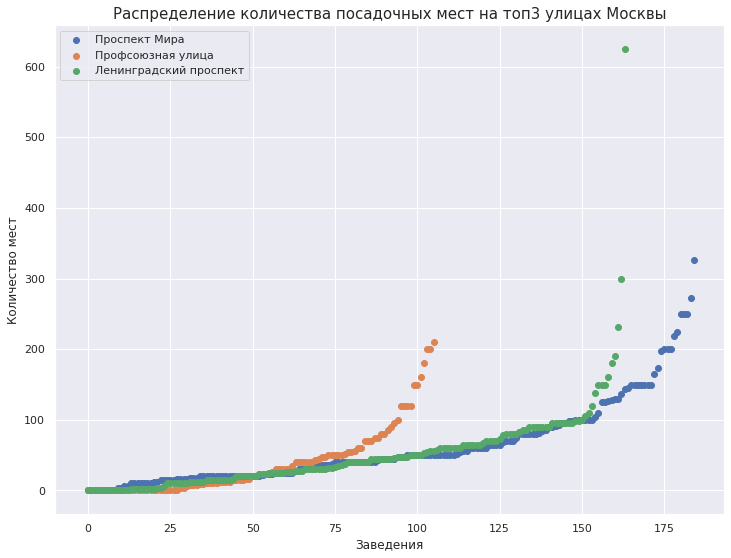

In [64]:
number_scatter_1 = pd.Series(range(0, len(top_10_merged_mira['id'])))
number_scatter_2 = pd.Series(range(0, len(top_10_merged_prof['id'])))
number_scatter_3 = pd.Series(range(0, len(top_10_merged_lenin['id'])))

plt.figure(figsize=(12, 9))
fig, scatter = plt.subplots()
scatter.scatter(number_scatter_1, top_10_merged_mira['number'], label = 'Проспект Мира')
scatter.scatter(number_scatter_2, top_10_merged_prof['number'], label = 'Профсоюзная улица')
scatter.scatter(number_scatter_3, top_10_merged_lenin['number'], label = 'Ленинградский проспект')
plt.title('Распределение количества посадочных мест на топ3 улицах Москвы', fontsize=15)
plt.xlabel('Заведения', fontsize=12)
plt.ylabel('Количество мест', fontsize=12)
scatter.legend();

Выполненный анализ позволяет сделать следующие выводы:
- проспект Мира - 185 объектов со средним количеством посадочных - 63 и медианой 45. По распределению видим сосредоточение большинства заведений в интервале от 20 до 100 мест;
- Профсоюзная улица - 106 объектов со средним количеством посадочных мест 39.8 и медианой 24. В данном случае видно смещение в меньшую сторону;
- Ленинградский проспект - 164 объектов со средним 52.4 и медианой 40 мест. Распределение основной группы заведений (до 100 мест) идентично проспекту Мира.

#### Сделать общий вывод и дать рекомендации о виде заведения, количестве посадочных мест и районе расположения. Указать на пути развития сети

Общий вывод:
1. Исходный датасет прдобработан: переименованы колонны, удалены дубликаты, выбраны строки, относящиеся только к Москве;
2. Наиболее распространенным видом заведения общепита является Кафе - около 6000;
3. Следом располагаются Столовая, Ресторан и Предприятие быстрого обслуживания от 1900 до 2600;
4. Наименьшее количество заведений в типах Закусочная, Кафетерий и Магазин (отдел кулинарии) - менее 400;
5. Категориальное распределение показало, что наиболее характерно сетевое распределение для предприятий быстрого обслуживания. Также большую долю сетевые общепиты занимают в кафе и ресторанах;
6. Распределение количества посадочных мест показывает, что до значения 100 идет постепенное увеличение количества мест от одного заведения к другому. После идет резкий рост (от 100 до 600). Статистическая характеристика подтверждает данное наблюдение и указывает, что 90% заведения имеют количество посадочных мест менее 120;
7. Распределение по среднему количеству посадочных мест среди заведений различного вида показывает, что больше всего мест в столовых - 130 и ресторанах - 97. Это объясняется спецификой заведений и потребностью в одновременном обслуживании большого количества гостей на месте. В случае с кафетерием, закусочной и отделом кулинарии в магазинах ситуация обратная и среднее количество посадочных мест не превышает 10;
8. Наиболее популярными для заведений общественного питания оказались проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе и Ленинский проспект Также много заведений на проспекте Вернадского, Кутузовском проспекте, Каширском шоссе и Коровоградской улице. Данные улицы в совокупности захватывают 58 районов

Решение о развитии сети прдлагается выполнять на основе трех критериев - вид заведения, количество мест и район. При внедрении инновации - роботов для обслуживания - нужно учитывать, что много нестандартных решений в других вопросах (вид, места, район) могут значительно повысить риск проекта.

Вид заведения:

Наиболее популярным видом заведения по итогам исследования оказались кафе. Подобное преимущество указывает на высокую "выживаемость" таких заведений относительно других групп и позволяет предположить, что данный тип заведений наилучшим образом подойдет для нашей задачи.

Количество посадочных мест:

Распределение количества посадочных мест для кафе во всей Москве установилось на уровне 40. При анализе заведений из топ3 выявлено, что медианное количество мест находится в интервале от 25 до 45 мест. При выборе количества посадочных мест стоит учитывать специфику обслуживания посетителей роботами и различные поведенческие факторы со стороны потребителей (возможно потребуется дополнительное исследование). На основе имеющейся информации стоит предположить, что для проекта заведения с роботами достаточным будет 30-35 посадочных мест.

Район распроложения:

Для привлечения внимания стоит в первую очередь рассматривать улицы из топ10, так как наибольшее количество заведений указывает на большую "проходимость" в этих районах. Среди топ 10 стоит начать с проспекта Мира, Профсоюзной улица и Ленинградского проспекта

### Подготовка презентации

https://docs.google.com/presentation/d/1wyT46N0Nc_PT1VTtmosogF4gB5bNiFpaHaemFEEhFLE/edit?usp=sharing